In [2]:
!git clone https://stefan-matcovici/language-detection.git
!pip install -r language-detection/requirements.txt

Cloning into 'language-detection'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 65 (delta 25), reused 40 (delta 9), pack-reused 0
Unpacking objects: 100% (65/65), done.
Branch 'cookiecutter' set up to track remote branch 'cookiecutter' from 'origin'.
Switched to a new branch 'cookiecutter'
     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 1.9MB 14.4MB/s 
     |████████████████████████████████| 983kB 36.2MB/s 
     |████████████████████████████████| 10.1MB 48.2MB/s 
     |████████████████████████████████| 174kB 39.7MB/s 
     |████████████████████████████████| 41.4MB 71kB/s 
     |████████████████████████████████| 2.2MB 46.1MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 870kB 50.6MB/s 
     |████████████████████████████████| 3.3MB 45.3

In [3]:
!cd language-detection; chmod u+x scripts/download_wili2018.sh; ./scripts/download_wili2018.sh

--2021-04-11 19:30:28--  https://zenodo.org/record/841984/files/wili-2018.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62403646 (60M) [application/octet-stream]
Saving to: ‘wili-2018.zip’

wili-2018.zip       100%[===================>]  59.51M  18.2MB/s    in 4.2s    

2021-04-11 19:30:34 (14.1 MB/s) - ‘wili-2018.zip’ saved [62403646/62403646]

Archive:  wili-2018.zip
  inflating: ./data/wili-2018/x_train.txt  
  inflating: ./data/wili-2018/y_train.txt  
  inflating: ./data/wili-2018/x_test.txt  
  inflating: ./data/wili-2018/y_test.txt  
  inflating: ./data/wili-2018/labels.csv  
  inflating: ./data/wili-2018/README.txt  
  inflating: ./data/wili-2018/urls.txt  


In [4]:
import sys
sys.path.append('/content/language-detection/src')

In [5]:
%load_ext autoreload
%autoreload 2

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sns


from data.wili2018_dataset import Wili2018Dataset
from data.wili2018_torch_dataset import Wili2018TorchDataset
from models.rnn_model import RNNModel

###torch setup

In [7]:
torch.manual_seed(27)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("WARNING: No GPU available")
    device = torch.device("cpu")

###Loading data

In [8]:
target_languages = ['eng', 'rus', 'fra', 'spa', 'deu', 'ita', 'nld', 'jpn', 'ara', 'hin', 'urd', 'por', 'fas', 'kor', 'est', 'ron', 'swe', 'tha']
wili2018 = Wili2018Dataset(target_languages)
X_train, Y_train, X_test, Y_test = wili2018.get_data()

In [9]:
def to_vocab(list_of_words, to_start=0):
    mapping = dict(enumerate(list_of_words, start=to_start))
    inverse_mapping = {v: k for k, v in mapping.items()}

    return inverse_mapping

vectorizer = CountVectorizer(analyzer='word', strip_accents='unicode', max_features=10_000).fit(X_train)
words = vectorizer.get_feature_names()
processor = vectorizer.build_analyzer()
vocab = to_vocab(words, 2)
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
        
target_classes = LabelEncoder().fit(Y_train).classes_
target_mapping = to_vocab(target_classes)

In [10]:
wili2018_train_dataset = Wili2018TorchDataset(X_train, Y_train, vocab, target_mapping, processor)
wili2018_test_dataset = Wili2018TorchDataset(X_test, Y_test, vocab, target_mapping, processor)

###Prepare data for training

In [11]:
def pad_sequence(batch):
    sorted_batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
    sequences = [torch.Tensor(x[0]).long() for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    lengths = torch.LongTensor([len(x) for x in sequences])
    labels = torch.LongTensor(list(map(lambda x: x[1], sorted_batch)))

    return sequences_padded, lengths, labels

In [12]:
train_loader = DataLoader(
        dataset=wili2018_train_dataset,
        batch_size=64,
        shuffle=True,
        pin_memory=True,
        collate_fn=pad_sequence,
        drop_last=True
    )

test_loader = DataLoader(
        dataset=wili2018_test_dataset,
        batch_size=64,
        shuffle=False,
        pin_memory=True,
        collate_fn=pad_sequence,
        drop_last=True
    )

###Model parameters

In [90]:
ntokens = len(vocab)
nclasses = len(target_mapping)
rnn_type = 'LSTM'
embedding_size = 300
hidden_size = 128

model = RNNModel(rnn_type, ntokens, embedding_size, hidden_size, nclasses, 1, 0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [91]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [92]:
def train(model, loader, criterion, optimizer, epoch, clip_range=0.1, log_interval=50):
    model.train()
    total_loss = 0.
    start_time = time.time()

    hidden = model.init_hidden(loader.batch_size)
    for batch_idx, (texts, lengths, targets) in enumerate(loader):
        model.zero_grad()

        hidden = repackage_hidden(hidden)
        output, hidden = model(texts.to(device), lengths, hidden)

        loss = criterion(output, targets.to(device))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_range)
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % log_interval == 0 and batch_idx > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print(f'| epoch {epoch:3d} | {batch_idx:5d}/{(len(X_train) // loader.batch_size):5d} batches | ms/batch {elapsed * 1000 / log_interval:5.2f}'
            f'| loss {cur_loss:5.2f} | acc {torch.sum(torch.argmax(output.cpu(), dim=1) == targets) }')
            total_loss = 0
            start_time = time.time()

In [93]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0.

    hidden = model.init_hidden(loader.batch_size)
    with torch.no_grad():
        for batch_idx, (texts, lengths, targets) in enumerate(loader):
            output, hidden = model(texts.to(device), lengths, hidden)
            hidden = repackage_hidden(hidden)
            total_loss += len(X_test) * criterion(output, targets.to(device)).item()
    return total_loss / (len(X_test) - 1)

In [94]:
import time
best_val_loss = None
model_path = 'model'

try:
    for epoch in range(1, 10):
        epoch_start_time = time.time()
        train(model, train_loader, criterion, optimizer, epoch)
        val_loss = evaluate(model, test_loader)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '.format(epoch, (time.time() - epoch_start_time), val_loss,))
        print('-' * 89)

        if not best_val_loss or val_loss < best_val_loss:
            print("Improved val loss so saving")
            with open(model_path, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |    50/  140 batches | ms/batch 33.27| loss  2.67 | acc 22
| epoch   1 |   100/  140 batches | ms/batch 31.21| loss  1.79 | acc 40
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  6.92s | valid loss 99.80 | 
-----------------------------------------------------------------------------------------
Improved val loss so saving
| epoch   2 |    50/  140 batches | ms/batch 32.95| loss  0.65 | acc 58
| epoch   2 |   100/  140 batches | ms/batch 28.79| loss  0.39 | acc 60
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  6.80s | valid loss 28.24 | 
-----------------------------------------------------------------------------------------
Improved val loss so saving
| epoch   3 |    50/  140 batches | ms/batch 32.13| loss  0.18 | acc 63
| epoch   3 |   100/  140 batches | ms/batch 29.88| loss  0.15 | acc 62
----------------------------------------

###Load the best saved model.

In [95]:
with open(model_path, 'rb') as f:
    model = torch.load(f)
    if rnn_type in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

test_loss = evaluate(model, test_loader)
print('=' * 89)
print('| End of training | test loss {:5.2f} '.format(test_loss))
print('=' * 89)

| End of training | test loss 17.81 


In [96]:
y_pred = []
y_true = []
model.eval()
total_loss = 0.

hidden = model.init_hidden(test_loader.batch_size)
with torch.no_grad():
    for batch_idx, (texts, lengths, targets) in enumerate(test_loader):

        output, hidden = model(texts.to(device), lengths, hidden)
        hidden = repackage_hidden(hidden)
        y_pred += torch.argmax(output, dim=1).tolist()
        y_true += [x.item() for x in targets]

###Classification report

In [97]:
print(classification_report(y_true, y_pred, target_names=set(Y_train), digits=4))

              precision    recall  f1-score   support

         rus     0.9980    0.9920    0.9950       499
         fra     0.9761    0.9840    0.9800       499
         eng     0.9512    0.9740    0.9625       500
         hin     0.9756    0.9677    0.9717       496
         urd     0.9899    0.9919    0.9909       494
         nld     0.9283    0.9919    0.9591       496
         jpn     0.9959    0.9760    0.9858       499
         swe     0.9919    0.9779    0.9848       498
         ita     0.9068    0.9359    0.9211       499
         fas     1.0000    0.9699    0.9847       499
         ara     0.9703    0.9879    0.9790       496
         por     0.9898    0.9719    0.9808       499
         kor     0.9515    0.9859    0.9684       497
         ron     0.9778    0.9680    0.9729       500
         deu     0.9957    0.9315    0.9625       496
         tha     0.9940    1.0000    0.9970       499
         est     0.9798    0.9738    0.9768       497
         spa     1.0000    

###Confusion matrix

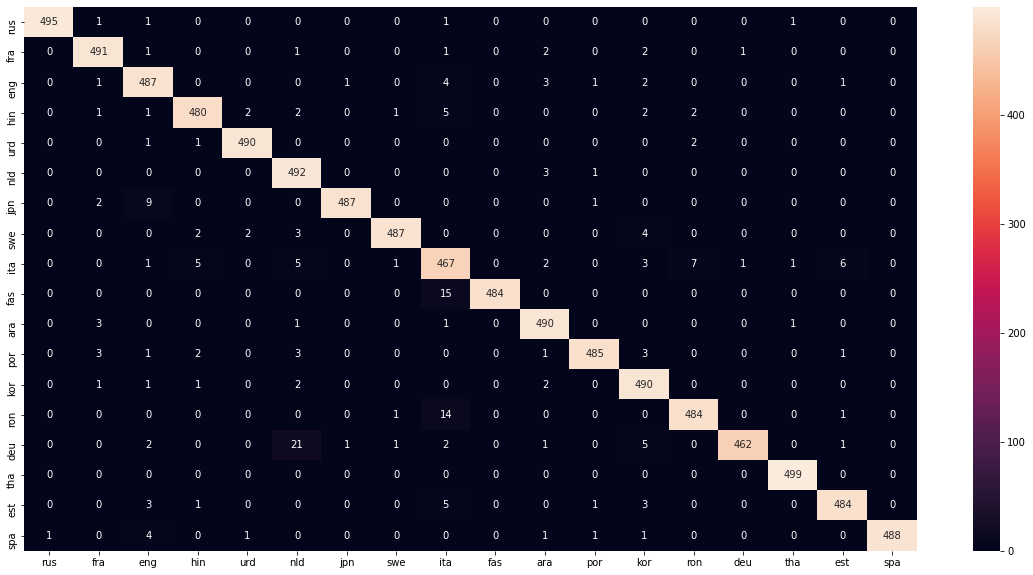

In [98]:
label_list = sorted(list(set(y_pred)))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (20, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=set(Y_train), yticklabels=set(Y_train))